## Plot covariances of features and filters

Do similar filters give rise to correlated filters?


In [1]:
# setup
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import torchvision
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from vis_utils import *
from model_def import *
from model_train import *

%matplotlib inline


### MLP

Compute the correlation matrix of features for the MLP network and then compare it

In [2]:
class MLPFeat(MLP):
    '''
        Inherit from MLP and return features from all layers in forward()
    '''
    def __init__(self, input_dim=3072, fc1_dim=100, fc2_dim=100):
        super(MLPFeat, self).__init__(input_dim=input_dim, fc1_dim=fc1_dim, fc2_dim=fc2_dim)

    def forward(self, x):
        x1_pre = self.fc1(x)
        x1 = F.relu(x1_pre)
        x2_pre = self.fc2(x1)
        x2 = F.relu(x2_pre)
        x3 = self.fc3(x2)
        return x1, x2, x3

In [3]:
def get_mlp_feat(expDir, w1, numBatches=50):   
    '''
        Return pre-ReLU features as NxD numpy array
    '''

    # Load trained MLP model
    net = MLPFeat(input_dim=3072, fc1_dim=w1, fc2_dim=100)
    net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
    
    # Get fc1 features for batches of 100 images each
    net.cuda()
    feat_fc1 = []
    feat_fc2 = []
    for i, data in enumerate(trainloader, 0):
        if i == numBatches:
            break
        inputs, _ = data
        x1, x2, _ = net.forward(Variable(inputs.cuda()))
        feat_fc1.append(x1)
        feat_fc2.append(x2)
        
    feat_1 = torch.cat(tuple(feat_fc1))
    feat_2 = torch.cat(tuple(feat_fc2))
    
    feat_1_n = torch.nn.functional.normalize(feat_1,2)
    feat_2_n = torch.nn.functional.normalize(feat_2,2)
    
    feat_1_n = feat_1_n.cpu()
    feat_2_n = feat_2_n.cpu()
    
    return feat_1_n.data.numpy(), feat_2_n.data.numpy() 
    

In [4]:
def get_corr_mat_dist(mat1, mat2):
    '''
        Correlation matrix distance (CMD)
    '''
    a = mat1.flatten()
    b = mat2.flatten()
    corr_mat_dist = 1 - \
    (np.inner(a,b)/(np.linalg.norm(a,ord=2)*np.linalg.norm(b,ord=2)) )
    return corr_mat_dist


Files already downloaded and verified
Files already downloaded and verified
0.239636426397
0.123902662175


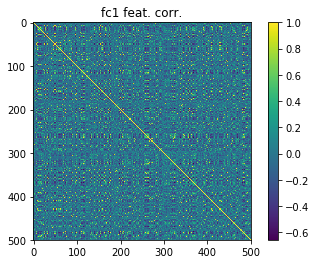

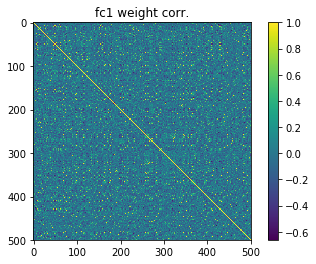

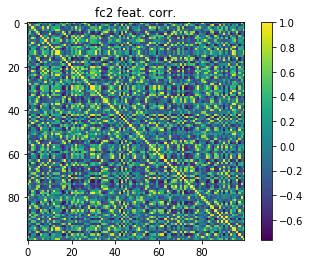

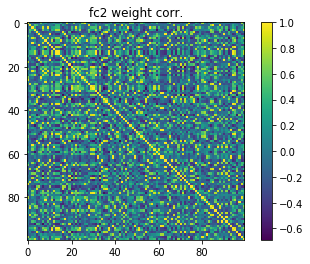

In [5]:
w1 = 500
batchSize = 100
w2 = 100
expName = 'cifar-mlp-v1_w1-%d' % w1 # pre-trained MLP - w1:500, w2:100
expDir = os.path.join('./data', expName)
outDir = './data/figures'
SAVE_FIG = False

# setup and load CIFAR dataset
trainloader, testloader, classes = setup_cifar_data_mlp(batchSize)

# get feature correlation matrix
feat_fc1, feat_fc2 = get_mlp_feat(expDir, w1,numBatches=500)
feat_corr_fc1 = np.corrcoef(feat_fc1.transpose())
feat_corr_fc2 = np.corrcoef(feat_fc2.transpose())

# get weights similarity matrix
net = MLP(input_dim=3072, fc1_dim=w1, fc2_dim=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
w_fc1, _ = get_layer_cosine_similarity(net, 'fc1.weight')
w_fc2,_ = get_layer_cosine_similarity(net, 'fc2.weight')

# correlation matrix distances
cmd_fc1 = get_corr_mat_dist(feat_corr_fc1, w_fc1)
cmd_fc2 = get_corr_mat_dist(feat_corr_fc2, w_fc2)


f1 = plt.figure()
plt.imshow(feat_corr_fc1)
plt.colorbar()
plt.title('fc1 feat. corr.')
if SAVE_FIG:
    f1.savefig(os.path.join(outDir,'mlp-fc1-feat-corr.pdf'), 
                            bbox_inches='tight')
    f1.savefig(os.path.join(outDir,'mlp-fc1-feat-corr.png'), 
                            bbox_inches='tight')

f2 = plt.figure()
plt.imshow(w_fc1)
plt.colorbar()
plt.title('fc1 weight corr.')
if SAVE_FIG:
    f2.savefig(os.path.join(outDir,'mlp-fc1-w-corr.pdf'), 
                            bbox_inches='tight')
    f2.savefig(os.path.join(outDir,'mlp-fc1-w-corr.png'), 
                            bbox_inches='tight')

print cmd_fc1

f3 = plt.figure()
plt.imshow(feat_corr_fc2)
plt.colorbar()
plt.title('fc2 feat. corr.')
if SAVE_FIG:
    f3.savefig(os.path.join(outDir,'mlp-fc2-feat-corr.pdf'), 
                            bbox_inches='tight')
    f3.savefig(os.path.join(outDir,'mlp-fc2-feat-corr.png'), 
                            bbox_inches='tight')

f4 = plt.figure()
plt.imshow(w_fc2)
plt.colorbar()
plt.title('fc2 weight corr.')
if SAVE_FIG:
    f4.savefig(os.path.join(outDir,'mlp-fc2-w-corr.pdf'), 
                            bbox_inches='tight')
    f4.savefig(os.path.join(outDir,'mlp-fc2-w-corr.png'), 
                            bbox_inches='tight')

print cmd_fc2


### CNN

Do the correlation comparison between features and filters for CNN.

In [90]:
class CNNFeat(NetWide):
    '''
        Inherit from MLP and return features from all layers in forward()
    '''
    def __init__(self, conv1_dim=100, conv2_dim=50):
        super(CNNFeat, self).__init__(conv1_num_filter=conv1_dim, \
                                      conv2_num_filter=conv2_dim)

    def forward(self, x):
        x1 = self.pool(F.relu(self.conv1(x)))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = x2.view(-1, self.c2 * 5 * 5)
        x4 = F.relu(self.fc1(x3))
        x5 = F.relu(self.fc2(x4))
        x6 = self.fc3(x5)
        return self.conv1(x), self.conv2(x1), x4, x5

In [91]:
# for CNN
w1 = 500
batchSize = 100
w2 = 50
expName = 'cifar-lenet-v1_w1-%d' % w1 # pre-trained MLP - w1:500, w2:100
expDir = os.path.join('./data', expName)
trainloader, testloader, classes = setup_cifar_data(batchSize)

Files already downloaded and verified
Files already downloaded and verified


In [92]:
def get_cnn_feat(expDir, w1, numBatches=50):   
    '''
        Return features as NxD numpy array
    '''

    # Load trained MLP model
    net = CNNFeat(conv1_dim=w1, conv2_dim=w2)
    net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
    
    # Get fc1 features for batches of 100 images each
    net.cuda()
    feat_fc1 = []
    feat_fc2 = []
    for i, data in enumerate(trainloader, 0):
        if i == numBatches:
            break
        inputs, _ = data
        x1, x2, _, _ = net.forward(Variable(inputs.cuda()))
        
        # flatten conv o/p tensor: 
        #    100x500x14x14 --> 100x14x14x500 --> 19600x500
        y1 = x1.permute(0,2,3,1).contiguous()
        y2 = x2.permute(0,2,3,1).contiguous()
        y1 = y1.view(-1,y1.size()[-1])
        y2 = y2.view(-1,y2.size()[-1])
        
        # sub-sample in a batch
        sel_1 = np.random.randint(0,y1.size()[0],size=(1,batchSize))
        sel_2 = np.random.randint(0,y2.size()[0],size=(1,batchSize))
        
        feat_fc1.append(y1[sel_1,:].squeeze().cpu())
        feat_fc2.append(y2[sel_2,:].squeeze().cpu())
        
    feat_1 = torch.cat(tuple(feat_fc1))
    feat_2 = torch.cat(tuple(feat_fc2))
    
    feat_1_n = torch.nn.functional.normalize(feat_1,2)
    feat_2_n = torch.nn.functional.normalize(feat_2,2)
    
#     feat_1_n = feat_1_n.cpu()
#     feat_2_n = feat_2_n.cpu()
    
    return feat_1_n.data.numpy(), feat_2_n.data.numpy() 
    

In [93]:
# sub-sample from each 14x14 or 5x5 block
feat_conv1 = []
feat_conv2 = []

# HACK: need to do this in loop, else always out of GPU memory!
for i in range(10):
    z1, z2 = get_cnn_feat(expDir, w1,numBatches=10)
    feat_conv1.append(z1)
    feat_conv2.append(z2)

feat_conv1 = np.asarray(feat_conv1)
feat_conv2 = np.asarray(feat_conv2)

# reshape stuff into data x filters
feat_conv1 = np.reshape(feat_conv1, (-1,feat_conv1.shape[2]))
feat_conv2 = np.reshape(feat_conv2, (-1,feat_conv2.shape[2]))
print feat_conv1.shape
print feat_conv2.shape





(10000, 500)
(10000, 50)


In [94]:
# get feature correlation matrix
feat_corr_c1 = np.corrcoef(feat_conv1.transpose())
feat_corr_c2 = np.corrcoef(feat_conv2.transpose())

# get weights similarity matrix
net = NetWide(conv1_num_filter=w1, conv2_num_filter=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))

w_c1, _ = get_layer_cosine_similarity(net, 'conv1.weight')
w_c2,_ = get_layer_cosine_similarity(net, 'conv2.weight')


# correlation matrix distances
cmd_c1 = get_corr_mat_dist(feat_corr_c1, w_c1)
cmd_c2 = get_corr_mat_dist(feat_corr_c2, w_c2)

0.176038819008
0.164004717703


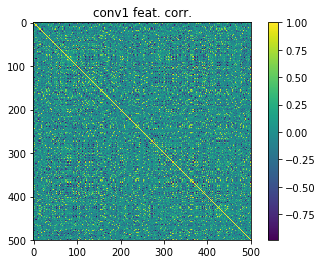

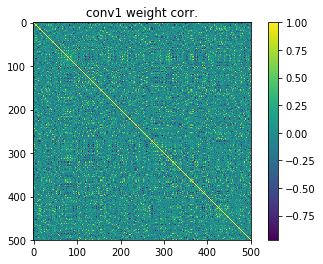

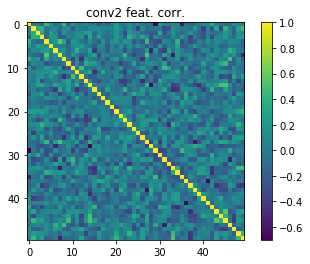

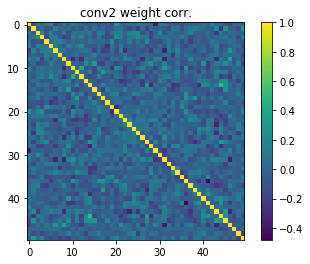

In [95]:

SAVE_FIG = False


f1 = plt.figure()
plt.imshow(feat_corr_c1)
plt.colorbar()
plt.title('conv1 feat. corr.')
if SAVE_FIG:
    f1.savefig(os.path.join(outDir,'mlp-fc1-feat-corr.pdf'), 
                            bbox_inches='tight')
    f1.savefig(os.path.join(outDir,'mlp-fc1-feat-corr.png'), 
                            bbox_inches='tight')

f2 = plt.figure()
plt.imshow(w_c1)
plt.colorbar()
plt.title('conv1 weight corr.')
if SAVE_FIG:
    f2.savefig(os.path.join(outDir,'mlp-fc1-w-corr.pdf'), 
                            bbox_inches='tight')
    f2.savefig(os.path.join(outDir,'mlp-fc1-w-corr.png'), 
                            bbox_inches='tight')

print cmd_c1

f3 = plt.figure()
plt.imshow(feat_corr_c2)
plt.colorbar()
plt.title('conv2 feat. corr.')
if SAVE_FIG:
    f3.savefig(os.path.join(outDir,'mlp-fc2-feat-corr.pdf'), 
                            bbox_inches='tight')
    f3.savefig(os.path.join(outDir,'mlp-fc2-feat-corr.png'), 
                            bbox_inches='tight')

f4 = plt.figure()
plt.imshow(w_c2)
plt.colorbar()
plt.title('conv2 weight corr.')
if SAVE_FIG:
    f4.savefig(os.path.join(outDir,'mlp-fc2-w-corr.pdf'), 
                            bbox_inches='tight')
    f4.savefig(os.path.join(outDir,'mlp-fc2-w-corr.png'), 
                            bbox_inches='tight')

print cmd_c2

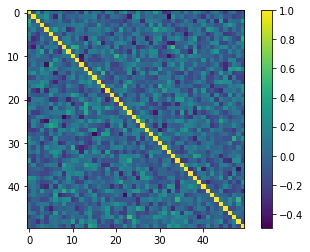

In [101]:
rand_cov = np.random.randn(50,50) / 6
np.fill_diagonal(rand_cov, 1.0)
plt.imshow(rand_cov)
plt.colorbar()

In [102]:
rand_cov = get_corr_mat_dist(rand_cov, w_c2)
print rand_cov

0.489242657197
